# ทำนายผลผลิตข้าวโพด โดยใช้ผลผลิตปีก่อน ๆ ด้วย SARIMAX


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

register_matplotlib_converters()

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

----
## Get Data

Read yield data

In [2]:
yield_file = 'OAE-process/OAE-ผลผลิตข้าวโพดทั้งหมด.xlsx'
df = pd.read_excel(yield_file)
df.head()

,date,product,key,area,lng,lat,value,unit,type,freq,level
0,2019-01-01,ข้าวโพด,ผลผลิตข้าวโพดทั้งหมด,Chiang Rai,19.899547,99.909809,3520,ตัน,volume,month,local
1,2019-01-01,ข้าวโพด,ผลผลิตข้าวโพดทั้งหมด,Phayao,19.215928,100.205901,1179,ตัน,volume,month,local
2,2019-01-01,ข้าวโพด,ผลผลิตข้าวโพดทั้งหมด,Lampang,18.297781,99.496366,6957,ตัน,volume,month,local
3,2019-01-01,ข้าวโพด,ผลผลิตข้าวโพดทั้งหมด,Lamphun,18.596625,99.011293,667,ตัน,volume,month,local
4,2019-01-01,ข้าวโพด,ผลผลิตข้าวโพดทั้งหมด,Chiang Mai,18.860754,98.966858,3718,ตัน,volume,month,local


Show areas with the maximum yield in the last 5 years.

In [3]:
df.groupby(['area']).sum().sort_values(by='value', ascending=False).head()

,lng,lat,value
area,,,
Phetchabun,864.630711,5358.773025,2510190
Nakhon Ratchasima,795.257633,5407.582633,1976058
Nan,996.372493,5341.332103,1874754
Tak,895.148217,5251.911033,1556337
Loei,927.586973,5390.832778,1416855


In [4]:
def yield_in_area(df, area):
    df = df.sort_values(by='date', ascending=True)
    df_area = df[df.area == area].reset_index()
    df_area = df_area[['date', 'value']]
    df_area.columns = ['ds', 'y']
    df_area = df_area.set_index('ds')
    df_area.index = pd.DatetimeIndex(df_area.index)
    return df_area['y']

In [5]:
df_nan = yield_in_area(df, 'Nan')
df_nan = df_nan.asfreq(pd.infer_freq(df_nan.index))
df_nan.head()

ds
2015-01-01    11233
2015-02-01     1195
2015-03-01     7079
2015-04-01    19287
2015-05-01     1585
Freq: MS, Name: y, dtype: int64

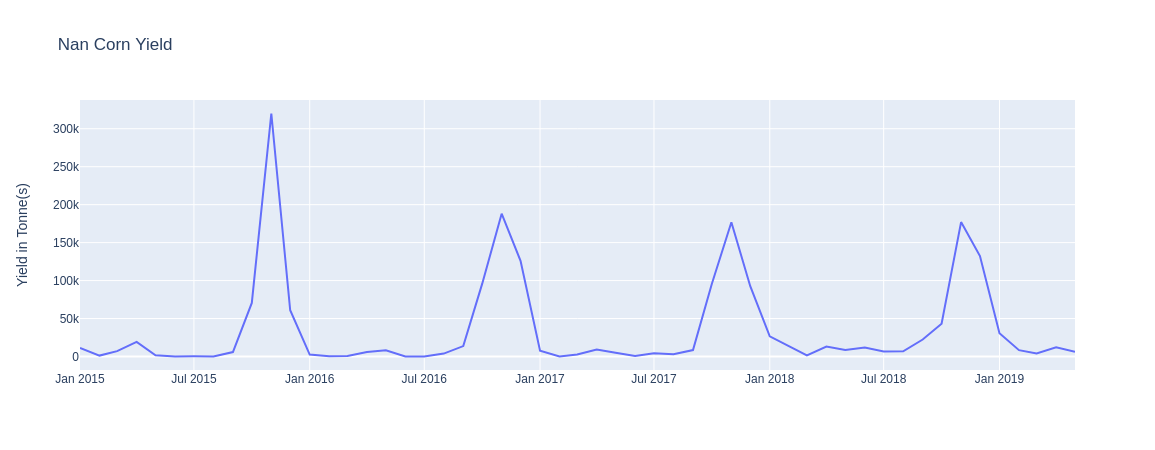

In [6]:
py.iplot({'data':go.Scatter(x=df_nan.index, y=df_nan, name='y'),
         'layout':dict(title = 'Nan Corn Yield',
                       yaxis = dict(title = 'Yield in Tonne(s)'))
         })

In [7]:
first_diff = df_nan.diff()[1:]

Text(0.5, 1.0, 'Diff yield')

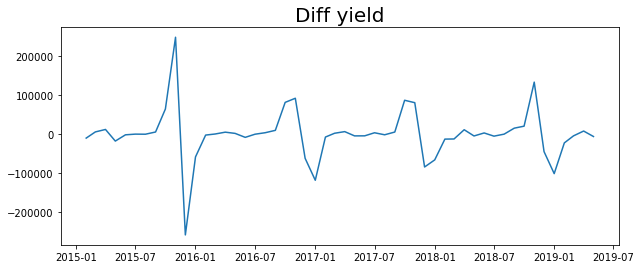

In [8]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Diff yield', fontsize=20)
# plt.ylabel('Sales', fontsize=16)
# for year in range(start_date.year,end_date.year):
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
# plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# ACF

/home/yoyo/anaconda3/envs/oae/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:652: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

/home/yoyo/anaconda3/envs/oae/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



<BarContainer object of 20 artists>

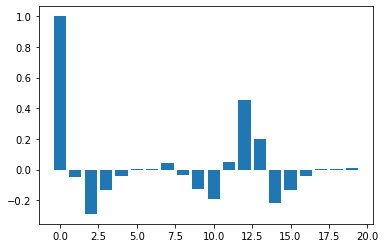

In [9]:
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a seasonal MA process

# PACF

/home/yoyo/anaconda3/envs/oae/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



<BarContainer object of 15 artists>

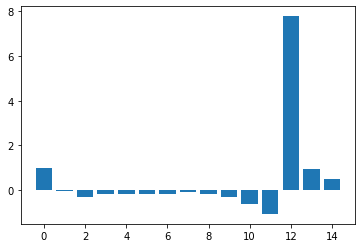

In [10]:
pacf_vals = pacf(first_diff, nlags=20)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [11]:
df_train, df_test = df_nan[:-12], df_nan[-12:]

In [12]:
df_train.head()

ds
2015-01-01    11233
2015-02-01     1195
2015-03-01     7079
2015-04-01    19287
2015-05-01     1585
Freq: MS, Name: y, dtype: int64

In [13]:
df_test.head()

ds
2018-06-01    11754
2018-07-01     6735
2018-08-01     6864
2018-09-01    22393
2018-10-01    43070
Freq: MS, Name: y, dtype: int64

# Fit the SARIMA Model

In [14]:
my_order = (1,1,0)
my_seasonal_order = (0, 1, 1, 12)
# define model
model = SARIMAX(df_train, order=my_order, seasonal_order=my_seasonal_order)

In [15]:
%%time
#fit the model
model_fit = model.fit()

/home/yoyo/anaconda3/envs/oae/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



CPU times: user 695 ms, sys: 15.8 ms, total: 711 ms
Wall time: 92.1 ms


In [16]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   41
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -326.977
Date:                              Thu, 08 Oct 2020   AIC                            659.954
Time:                                      14:29:16   BIC                            663.951
Sample:                                  01-01-2015   HQIC                           661.176
                                       - 05-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6069      0.211     -2.878      0.004      -1.020      -0.194
ma.S.L12      -0.47

In [17]:
#get the predictions and residuals
predictions = model_fit.forecast(len(df_test))
predictions = pd.Series(predictions, index=df_test.index)
residuals = df_test - predictions

Text(0, 0.5, 'Error')

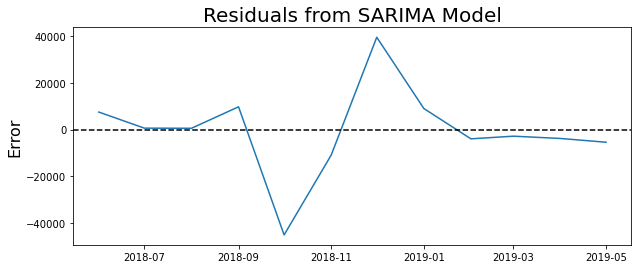

In [18]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

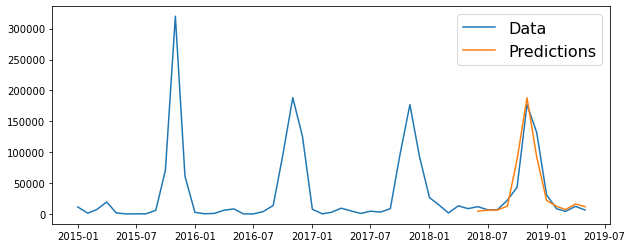

In [19]:
plt.figure(figsize=(10,4))

plt.plot(df_nan)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

In [20]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/df_test)),4))

Mean Absolute Percent Error: 0.4403


In [21]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 18300.54460614966
